In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics.cluster import adjusted_rand_score

In [11]:
# Create training, development, and testing sets

tweets_df = pd.read_csv("tweets_df.txt", index_col = 0)

X = tweets_df.values[:,:-2]
y = tweets_df.values[:, -2]
movies = tweets_df.values[:, -1]

train_idx = np.where((movies == 1) | (movies == 3))[0]
dev_idx   = np.where(movies == 2)[0]
test_idx  = np.where(movies == 0)[0]

X_train, X_dev, X_test = X[train_idx,], X[dev_idx,], X[test_idx,]
y_train, y_dev, y_test = y[train_idx,], y[dev_idx,], y[test_idx,]

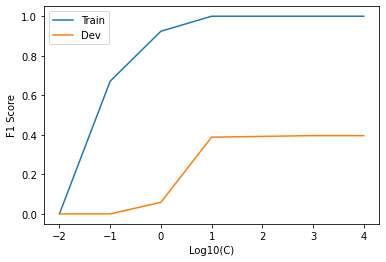

In [12]:
# Evaluate support vector classifier for various C values

train_scores, dev_scores = [], []
c_vals = [10e-3, 10e-2, 10e-1, 1, 10, 10e2, 10e3]
for c in c_vals:
  clf = SVC(C=c)
  clf.fit(X_train, y_train)
  y_train_pred = clf.predict(X_train)
  train_scores.append(metrics.f1_score(y_train, y_train_pred))
  y_dev_pred = clf.predict(X_dev)
  dev_scores.append(metrics.f1_score(y_dev, y_dev_pred))

c_logs = np.log10(c_vals)
plt.plot(c_logs, train_scores, label='Train')
plt.plot(c_logs, dev_scores, label='Dev')
plt.xlabel('Log10(C)')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

We notice that the development set F1 score increases marginally after C = 10, suggesting mild overfitting. Thus, we select C = 10 as the best C value.

In [13]:
# Retrain the model on train and dev set
all_train_idx = np.concatenate((train_idx, dev_idx))
X_all_train = X[all_train_idx]
y_all_train = y[all_train_idx]
clf = SVC(C=10)
clf.fit(X_all_train, y_all_train)

# Test final model on test set
y_test_pred = clf.predict(X_test)
score = metrics.f1_score(y_test, y_test_pred)
print('Test F1 Score: ', score)

Test F1 Score:  0.9162011173184357


In [14]:
def plot_scatter(embedding_2d, labels, show = True, title = None):
    """
    Visualize 2D data

    Parameters
    --------------------
        embedding_2d   -- numpy array of shape (n,2) samples
        labels         -- numpy array of shape (n,) labels
        show           -- optional boolean indicator on if display the visualziation, default set to True 
        title          -- optional string indicating what should be the title, default set to None
    --------------------
        None    
    """
    
    plt.scatter(embedding_2d[:,0], embedding_2d[:,1], c = labels) 
    if title is not None:
        plt.title(title)
    if show:
        plt.show() 

In [15]:
# Create embedding

pca = PCA(n_components=2)
pca.fit(X)
X_embedding = pca.transform(X)

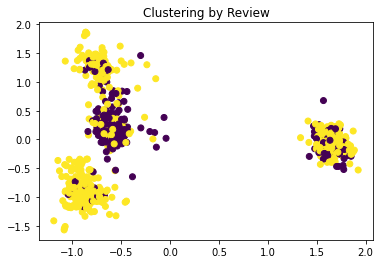

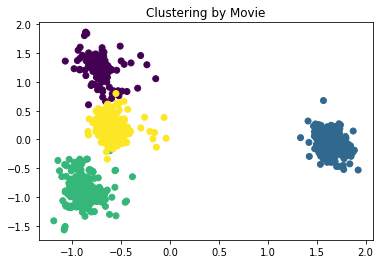

In [16]:
# Color the dots by review and by movies
plot_scatter(X_embedding, labels=tweets_df['labels'], title='Clustering by Review')
plot_scatter(X_embedding, labels=tweets_df['movies'], title='Clustering by Movie')

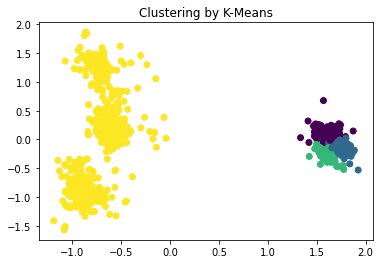

K-Means Rand Index:  0.25935622456493296


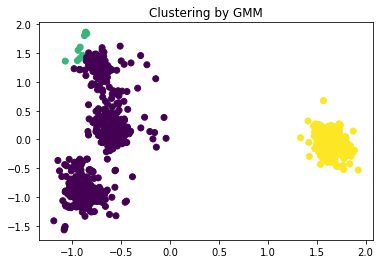

GMM Rand Index:  0.4189198834394529


In [17]:
# Color the dots by Kmeans and GMM using 1 iteration

kmeans = KMeans(n_clusters=4, init='random', n_init=1, random_state=2).fit(X_embedding)
plot_scatter(X_embedding, kmeans.labels_, title='Clustering by K-Means')
score = adjusted_rand_score(tweets_df['movies'], kmeans.labels_)
print('K-Means Rand Index: ', score)

gmm = GaussianMixture(n_components=4, random_state=0, init_params='random', n_init=1).fit(X_embedding)
gmm_labels = gmm.predict(X_embedding)
plot_scatter(X_embedding, gmm_labels, title='Clustering by GMM')
score = adjusted_rand_score(tweets_df['movies'], gmm_labels)
print('GMM Rand Index: ', score)

Because both algorithms converge to local minima, we see that we need to run multiple iterations in order to obtain better clusterings.

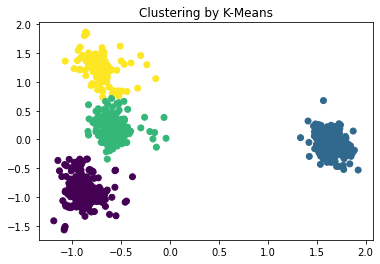

K-Means Rand Index:  0.9824442429232366


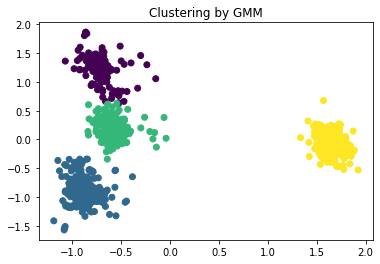

GMM Rand Index:  0.982486480501798


In [18]:
# Color the dots by Kmeans and GMM using 100 iterations

kmeans = KMeans(n_clusters=4, init='random', n_init=100, random_state=2).fit(X_embedding)
plot_scatter(X_embedding, kmeans.labels_, title='Clustering by K-Means')
score = adjusted_rand_score(tweets_df['movies'], kmeans.labels_)
print('K-Means Rand Index: ', score)

gmm = GaussianMixture(n_components=4, random_state=0, init_params='random', n_init=100).fit(X_embedding)
gmm_labels = gmm.predict(X_embedding)
plot_scatter(X_embedding, gmm_labels, title='Clustering by GMM')
score = adjusted_rand_score(tweets_df['movies'], gmm_labels)
print('GMM Rand Index: ', score)

100 iterations are sufficient to obtain optimal clusterings for both algorithms.